The code below will generate images after training our network just with random noise (no MFCC coefficients). We have mode collapse problems, so the generated faces are always more or less the same. 
You can change the variable images_to_generate to generate more faces.

(Please restart the kernel each time you run the code)


  [TL] InputLayer  generator/in: (?, 256)
  [TL] DenseLayer  generator/Generator/dense2: 4096 identity
  [TL] LambdaLayer  generator/lambda_layer
  [TL] Conv2dLayer generator/Generator/conv1: shape:[3, 3, 64, 64] strides:[1, 1, 1, 1] pad:SAME act:elu
  [TL] Conv2dLayer generator/Generator/conv2: shape:[3, 3, 64, 64] strides:[1, 1, 1, 1] pad:SAME act:elu
  [TL] UpSampling2dLayer Generator/UpSampling1: is_scale:True size:[16, 16] method:1 align_corners:False
  [TL] Conv2dLayer generator/Generator/conv3: shape:[3, 3, 64, 64] strides:[1, 1, 1, 1] pad:SAME act:elu
  [TL] Conv2dLayer generator/Generator/conv4: shape:[3, 3, 64, 64] strides:[1, 1, 1, 1] pad:SAME act:elu
  [TL] UpSampling2dLayer Encoder/UpSampling2: is_scale:True size:[32, 32] method:1 align_corners:False
  [TL] Conv2dLayer generator/Generator/conv5: shape:[3, 3, 64, 64] strides:[1, 1, 1, 1] pad:SAME act:elu
  [TL] Conv2dLayer generator/Generator/conv6: shape:[3, 3, 64, 64] strides:[1, 1, 1, 1] pad:SAME act:elu
  [TL] UpSamplin

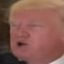

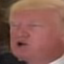

In [1]:
import tensorlayer as tl
import os
from tensorlayer.layers import *
import argparse
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display

def denorm_img(norm):
    return tf.clip_by_value((norm + 1)*127.5, 0, 255)

def restore_model(sess, checkpoint_path):
    # Get the state of the checkpoint and then restore using ckpt path
    ckpt = tf.train.get_checkpoint_state(checkpoint_path)

    if checkpoint_path is not None:
        restorer = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="generator"))
        restorer.restore(sess, ckpt.model_checkpoint_path)


def generator(z, reuse, hidden_number=64, kernel=3):
    w_init = tf.random_normal_initializer(stddev=0.02)

    with tf.variable_scope("generator", reuse=reuse):
        tl.layers.set_name_reuse(reuse)

        # DECODER BEGINS
        x = InputLayer(z, name="in")
        x = DenseLayer(x, n_units=8 * 8 * hidden_number, name='Generator/dense2')
        arguments = {'shape': [-1, 8, 8, hidden_number], 'name': 'Generator/reshape1'}
        x = LambdaLayer(x, fn=tf.reshape, fn_args=arguments)
        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, hidden_number], strides=[1, 1, 1, 1], padding='SAME',
                        W_init=w_init, act=tf.nn.elu, name='Generator/conv1')
        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, hidden_number], strides=[1, 1, 1, 1], padding='SAME',
                        W_init=w_init, act=tf.nn.elu, name='Generator/conv2')
        x = UpSampling2dLayer(x, size=[2, 2], is_scale=True, method=1, name='Generator/UpSampling1')  # method= 1 NN

        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, hidden_number], strides=[1, 1, 1, 1], padding='SAME',
                        W_init=w_init, act=tf.nn.elu, name='Generator/conv3')
        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, hidden_number], strides=[1, 1, 1, 1], padding='SAME',
                        W_init=w_init, act=tf.nn.elu, name='Generator/conv4')
        x = UpSampling2dLayer(x, size=[2, 2], is_scale=True, method=1, name='Encoder/UpSampling2')  # method= 1 NN

        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, hidden_number], strides=[1, 1, 1, 1], padding='SAME',
                        W_init=w_init, act=tf.nn.elu, name='Generator/conv5')
        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, hidden_number], strides=[1, 1, 1, 1], padding='SAME',
                        W_init=w_init, act=tf.nn.elu, name='Generator/conv6')
        x = UpSampling2dLayer(x, size=[2, 2], is_scale=True, method=1, name='Generator/UpSampling3')  # method= 1 NN

        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, hidden_number], strides=[1, 1, 1, 1],
                        padding='SAME',
                        W_init=w_init, act=tf.nn.elu, name='Generator/conv7')
        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, hidden_number], strides=[1, 1, 1, 1], padding='SAME',
                        W_init=w_init, act=tf.nn.elu, name='Generator/conv8')
        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, 3], strides=[1, 1, 1, 1], padding='SAME',
                        W_init=w_init, name='Generator/convLAST')

        return x


def test(images_to_generate, z_num = 256, reuse = True, checkpoint = "checkpoint1"):
    # ##========================== DEFINE INPUT DATA ============================###
    z = tf.placeholder('float32', [None, z_num], name='t_noise_generator')

    # ##========================== DEFINE MODEL ============================###
    net_gen = generator(z=z, reuse=reuse)

    output_gen = denorm_img(net_gen.outputs)  # Denormalization

    with tf.Session() as sess:
        print("Restoring model from checkpoint")
        restore_model(sess, checkpoint)

        for iteration in range(0, images_to_generate):
            input_z = np.random.uniform(-1., 1., size=[1, z_num])
            output_image = sess.run(output_gen, feed_dict={z: input_z})[0]
            ima = Image.fromarray(output_image.astype(np.uint8), 'RGB')
            display(ima)
            iteration += 1



if __name__ == '__main__':
    test(images_to_generate = 2)

